In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse


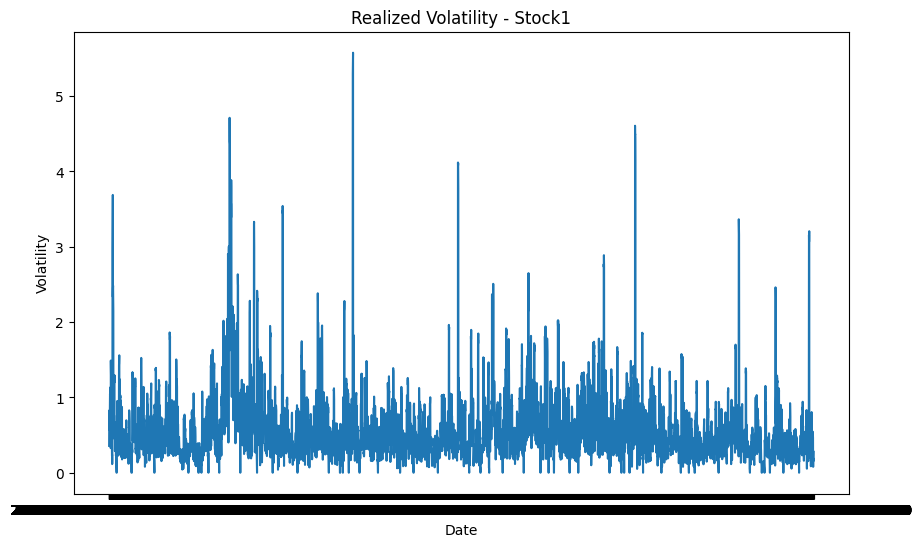

In [9]:


# Load the CSV data
df = pd.read_csv('Price_data.csv')

# Set the 'time' column as the index
df.set_index('Time', inplace=True)

# Select one stock column (e.g., 'stock1')
stock = df['AOS']

# Calculate returns
ret = 100 * stock.pct_change().dropna()

# Calculate rolling realized volatility (e.g., using a 5-period rolling window)
realized_vol = ret.rolling(5).std()

# Plot the realized volatility
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index, realized_vol)
plt.title('Realized Volatility - Stock1')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [12]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Time']

X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

svr_poly = SVR(kernel='poly', degree=2) 
svr_lin = SVR(kernel='linear') 
svr_rbf = SVR(kernel='rbf') 

Best parameters found by RandomizedSearchCV: {'C': 0.5184504247435934, 'epsilon': 0.18517946040324806, 'gamma': 0.6070594278446609}
The RMSE value of SVR with Linear Kernel is 0.000767


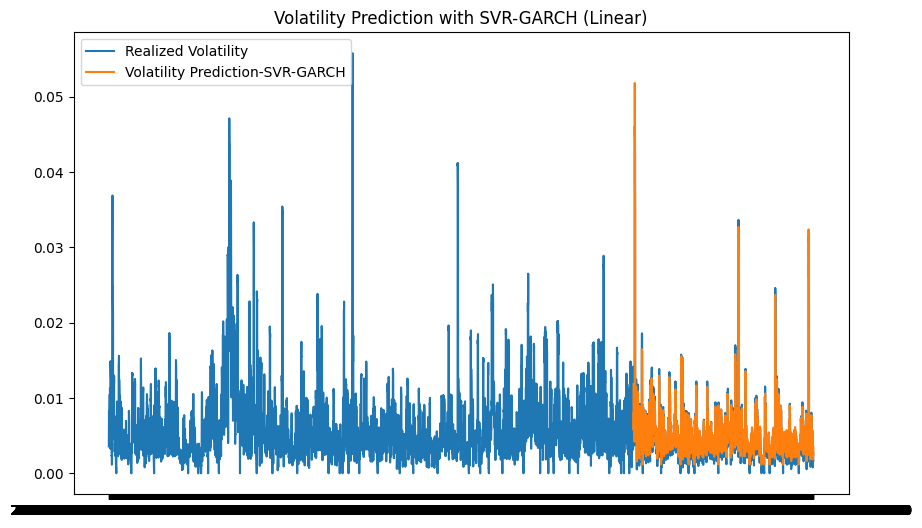

In [25]:
n = 2000
para_grid = {'gamma': sp_rand(),
                      'C': sp_rand(),
                      'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values,
                 realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

# Get the best parameters
best_params = clf.best_params_
print("Best parameters found by RandomizedSearchCV:", best_params)

predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
               .format(rmse_svr))

realized_vol.index = ret.iloc[4:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

Best parameters found by RandomizedSearchCV: {'C': 0.4282662631807097, 'epsilon': 0.1424579743032226, 'gamma': 0.35336168989437566}
The RMSE value of SVR with RBF Kernel is  0.001039


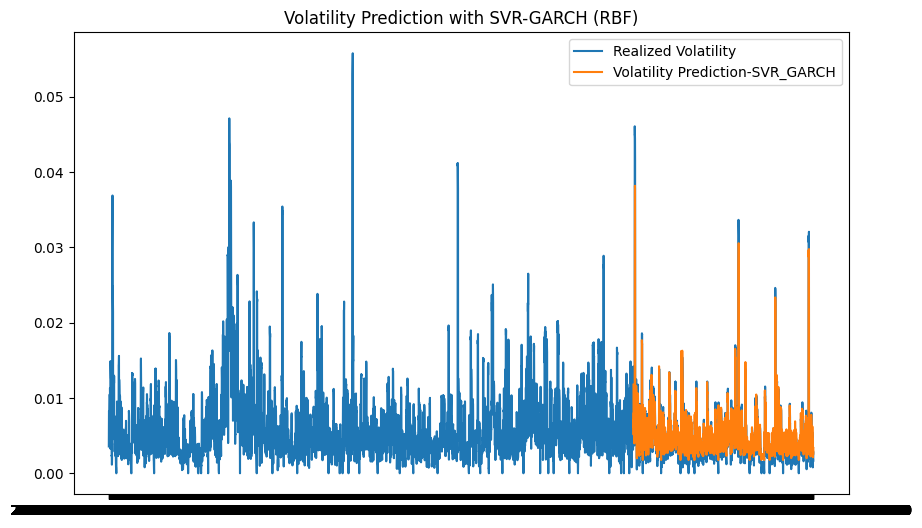

In [26]:
para_grid ={'gamma': sp_rand(),
                     'C': sp_rand(),
                     'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values,
                 realized_vol.iloc[1:-(n-1)].values.reshape(-1,))

# Get the best parameters
best_params = clf.best_params_
print("Best parameters found by RandomizedSearchCV:", best_params)

predict_svr_rbf = clf.predict(X.iloc[-n:])


predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                    predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
               .format(rmse_svr_rbf))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

Best parameters found by RandomizedSearchCV: {'C': 0.6665746287873214, 'epsilon': 0.33155467893464374, 'gamma': 0.7652614580880384}
The RMSE value of SVR with Polynomial Kernel is 0.002195


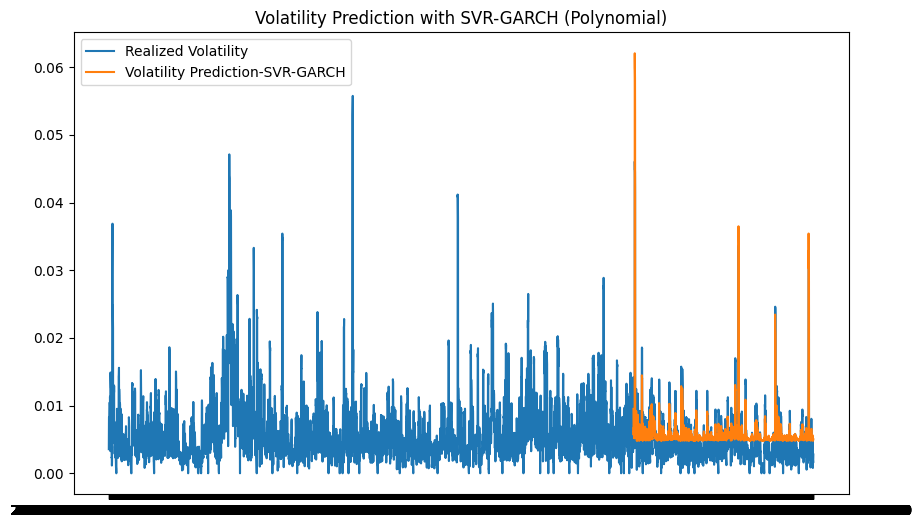

In [27]:
para_grid = {'gamma': sp_rand(),
                     'C': sp_rand(),
                     'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values,
                 realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
# Get the best parameters
best_params = clf.best_params_
print("Best parameters found by RandomizedSearchCV:", best_params)
predict_svr_poly = clf.predict(X.iloc[-n:])

predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                     predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'
               .format(rmse_svr_poly))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
                   fontsize=12)
plt.legend()
plt.show()

The RMSE value of NN is 0.000984


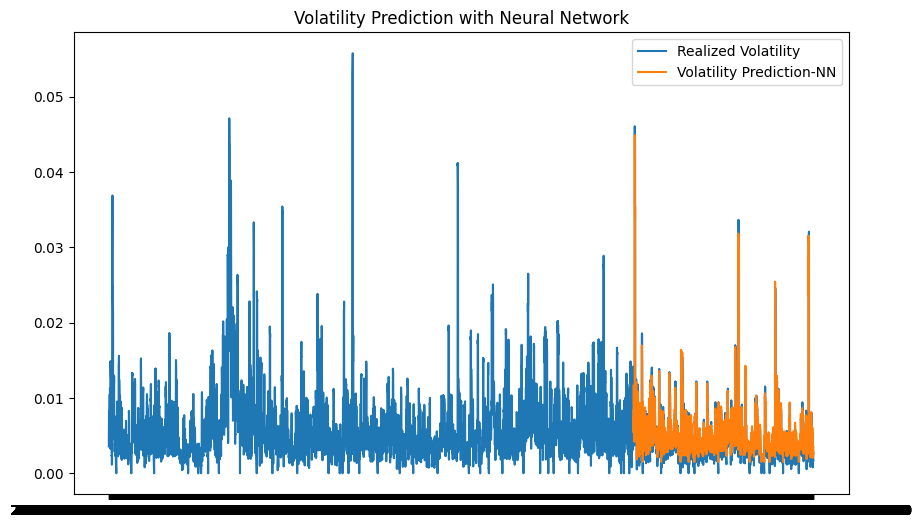

In [26]:
from sklearn.neural_network import MLPRegressor 
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                        'max_iter': [500, 1000],
                        'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values,
                 realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                               NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

Training model 1/81 with parameters: (0.001, 0.1, 100, 100)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DL_RMSE_1:0.000838
Training model 2/81 with parameters: (0.001, 0.1, 100, 400)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
DL_RMSE_2:0.001131
Training model 3/81 with parameters: (0.001, 0.1, 100, 4)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
DL_RMSE_3:0.000748
Training model 4/81 with parameters: (0.001, 0.1, 400, 100)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DL_RMSE_4:0.001051
Training model 5/81 with parameters: (0.001, 0.1, 400, 400)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
DL_RMSE_5:0.001000
Training model 6/81 with parameters: (0.001, 0.1, 400, 4)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DL_RMSE_6:0.000602
Training model 7/81 with parameters: (0.001, 0.1, 4, 100)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
DL_RMSE_7:0.001111
Training model 8/81 with parameters: (0.001, 0.1, 4, 400)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
DL_RMSE_8:0.001527
Training model 9/81 with parameters: (0.001, 0.1, 4, 4)
63/6

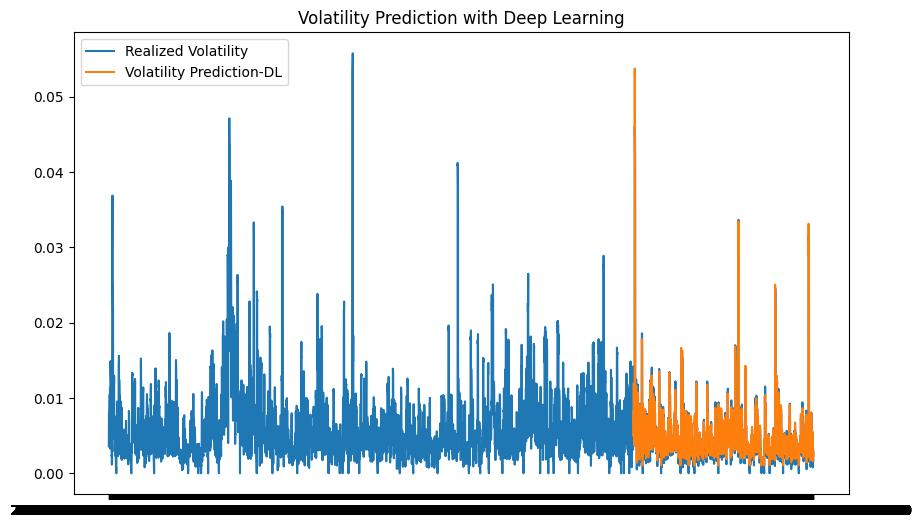

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import ParameterSampler
from itertools import product

# Define the model architecture with dropout layers
def create_model(learning_rate, dropout_rate):
    model = keras.Sequential([
        layers.Dense(256, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation="linear"),
    ])

    # Compile the model with the given learning rate
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Define the hyperparameter search space
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.1, 0.2, 0.3],
    'epochs' : [100,400,4],
    'batch_size' : [100,400,4]
}

# Generate random combinations of hyperparameters
param_list = list(product(*param_grid.values()))

# Lists to store predictions and RMSE for each set of hyperparameters
DL_pred_list = []
DL_RMSE_list = []

# Loop through different combinations of hyperparameters
for i, params in enumerate(param_list):
    print(f"Training model {i+1}/{len(param_list)} with parameters: {params}")
    learning_rate, dropout_rate, epochs, batch_size = params
    model = create_model(learning_rate, dropout_rate)
    
    # Train the model
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,), 
              epochs=epochs, batch_size=batch_size, verbose=False)
    
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE_list.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100, DL_predict.flatten() / 100)))
    DL_pred_list.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE_list[i]))

# Select the best set of hyperparameters based on the lowest RMSE
best_params = param_list[np.argmin(DL_RMSE_list)]
best_DL_predict = DL_pred_list[np.argmin(DL_RMSE_list)]

print("Best parameters:", best_params)
print("Best RMSE:", min(DL_RMSE_list))

# Convert best_DL_predict to a DataFrame and set the index
best_DL_predict_df = pd.DataFrame(best_DL_predict, index=ret.iloc[-n:].index)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(best_DL_predict_df / 100, label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning', fontsize=12)
plt.legend()
plt.show()

